<h1>Agave on Python</h1>
This tutorial follows the steps of setting up an Agave Portal using a Python3-based Jupyter notebook. Despite using Python3 as the default language, the focus of this notebook is really on the shell commands the user would issue to perform the various operations. This is facilitated by the notebook's shell escapes, e.g. "!echo hello".

The notebook follows the steps to setting up the portal from beginning to end, calling out the steps you might need to run when setting up for the first time, or when using it at a later date.

In [97]:
# Here we define some utility commands to simplify interaction with the shell.
# You don't need to read or understand this, but it's here in case you want to.
import re
import os
def repvar(v):
    """
    repvar() is short for "Replace Variables." The idea is that this
    function looks for strings of the form $VAR or ${VAR} or even
    $(CMD) in the input string and replaces them, either with
    the contents of os.environ[VAR] or os.pipe(CMD), mimicking the
    behavior of bash. If a backslace precedes the $, then the backslash
    will be removed but the string will not be evaluated. Thus:
    ${HOME} becomes "/home/user"
    $HOME becomes "/home/usr"
    $(echo Hello) becomes "Hello"
    \$HOME becomes $HOME
    """
    epos = 0
    buf = ''
    for g in re.finditer(r'\$((\w+)|\{([^}]*)\}|\(([^())]*)\))|(\\+\$)',v):
        if g:
            i = 2
            while g.group(i) == None:
                i += 1
            p = g.start(0)
            buf += v[epos:p]
            epos = p + len(g.group(0))
            if i == 4:
                fh = os.popen(g.group(i),"r")
                c = repvar(fh.read())
                fh.close()
            elif i == 5:
                c = '$'
            else:
                if not g.group(i) in os.environ:
                    raise Exception("no such environment variable: "+g.group(i))
                c = repvar(os.environ[g.group(i)])
            buf += c
        else:
            break
    buf += v[epos:]
    return buf.strip()
def setvar(e):
    """
    setvar() emulates the ability of BASH to set environment variables.
    Thus, NAME=VALUE will set os.environ["NAME"]="VALUE". Bash-style
    comments will be stripped, and bash-line continuations will be processed.
    """
    e = re.sub(r'#[^\r\n]*','',e)
    e = re.sub(r'\\\n\s*','',e)
    for m in re.finditer(r'(?m)(\w+)=(.*)',e):
        k = m.group(1)
        v = repvar(m.group(2))
        print(k+"="+v)
        os.environ[k]=v
def readfile(f):
    """
    Reads in a file. repvar() will be applied to the file name.
    """
    n = repvar(f)
    print("Reading file `"+n+"'")
    fh = open(n)
    c = fh.read()
    fh.close()
    return c
def writefile(f,c):
    """
    Writes out a file. repvar() will be applied both to the file name
    and the file contents.
    """
    n = repvar(f)
    print("Writing file `"+n+"'")
    fh = open(n,"w")
    fh.write(repvar(c))
    fh.close()

### Run Every Time
A lot of detailed configuration needs to be
set if we're to use Agave to run on a remote
machine. If you don't have an Agave account,
you can get one here: https://public.agaveapi.co/create_account

In [98]:
# This contains nearly all the configuration
# required by the tutorial. Please edit and adjust
# according to your needs. Each NAME=VALUE line
# sets the corresponding os.environment variable,
# and prints out the assignment so you can see the
# value that was assigned.
setvar("""
MACHINE=shelob.hpc.lsu.edu
AGAVE_USERNAME=stevenrbrandt
MACHINE_USERNAME=sbrandt
BASE_APP_NAME=drawgau
PORT=22
WORK_DIR=/work/${MACHINE_USERNAME}
HOME_DIR=/home/${MACHINE_USERNAME}
SCRATCH_DIR=/work/${MACHINE_USERNAME}
EMAIL=sbrandt@cct.lsu.edu
DEPLOYMENT_PATH=agave-deployment
ALLOCATION=hpc_hyrel17
""")

MACHINE=shelob.hpc.lsu.edu
AGAVE_USERNAME=stevenrbrandt
MACHINE_USERNAME=sbrandt
BASE_APP_NAME=drawgau
PORT=22
WORK_DIR=/work/sbrandt
HOME_DIR=/home/sbrandt
SCRATCH_DIR=/work/sbrandt
EMAIL=sbrandt@cct.lsu.edu
DEPLOYMENT_PATH=agave-deployment
ALLOCATION=hpc_hyrel17


<h2>Get Passwords</h2>
The next two commands load passwords that you will need to issue during the tutorial into memory.
We use python3's getpass() facility to avoid displaying said passwords on the screen.

In [3]:
from getpass import getpass
print(repvar("Password for $AGAVE_USERNAME"))
os.environ["AGAVE_PASSWD"]=getpass()

Password for stevenrbrandt
········


In [5]:
print(repvar("Password for $MACHINE_USERNAME"))
MACHINE_PASSWD=getpass()

Password for sbrandt
········


In [6]:
import re
g=re.match(r'([^\.]*)\.(.*)',os.environ["MACHINE"])
os.environ["MACH"]=g.group(1)
os.environ["NETWORK"]=g.group(2)
print(repvar("""
Configuring for Machine: $MACH
Full Name: `$MACHINE'
Network: `$NETWORK'
"""))

Configuring for Machine: shelob
Full Name: `shelob.hpc.lsu.edu'
Network: `hpc.lsu.edu'


In [7]:
setvar("APP_NAME=${BASE_APP_NAME}-${MACH}-${AGAVE_USERNAME}")

APP_NAME=drawgau-shelob-stevenrbrandt


In [8]:
setvar("PATH=$HOME/agave/cli/bin:$PATH")

PATH=/home/sbrandt/agave/cli/bin:/usr/local/bin/anaconda2/bin:/root/anaconda2/bin:/usr/local/bin/anaconda2/bin:/root/anaconda2/bin:/usr/local/sbin:/usr/local/bin:/sbin:/bin:/usr/sbin:/usr/bin:/root/bin


In [9]:
%mkdir -p ~/agave

In [10]:
%cd ~/agave

/home/sbrandt/agave


In [11]:
setvar("AGAVE_JSON_PARSER=jq")

AGAVE_JSON_PARSER=jq


## The next few cells only needs to be  run the first time

Before you run them, create a password for yourself and copy it into the paste buffer.

BTW, if you need to create a password, here's a nice password generator: https://www.cct.lsu.edu/~sbrandt/passwds.php

In [12]:
!git clone https://bitbucket.org/agaveapi/cli.git

Cloning into 'cli'...
remote: Counting objects: 2384, done.
remote: Compressing objects: 100% (994/994), done.
remote: Total 2384 (delta 1956), reused 1664 (delta 1380)  
Receiving objects: 100% (2384/2384), 14.86 MiB | 5.68 MiB/s, done.
Resolving deltas: 100% (1956/1956), done.


In [13]:
# This prepares your linux account for use with Agave.
!tenants-init -t agave.prod

You are now configured to interact with the APIs at https://public.agaveapi.co/


Agave requires you to have a client (really, just a name that you make up# associated with your account. The commands below either create, or recreate that client.
From time to time your login credentials will become messed up and you will need to
delete and recreate your client. Otherwise, you will be able to use auth-tokens-refresh
to renew your Agave credentials.

In [14]:
!clients-delete -u $AGAVE_USERNAME -p "$AGAVE_PASSWD" $APP_NAME 

Successfully deleted client drawgau-shelob-stevenrbrandt


In [16]:
!clients-create -p "$AGAVE_PASSWD" -S -N $APP_NAME -u $AGAVE_USERNAME

Successfully created client drawgau-shelob-stevenrbrandt
key: TrLtGty709cUhyszJM6S3oHNOO4a 
secret: ypyoIPk5Vpj0RiEwqYfSMpftvAoa


In [17]:
!auth-tokens-create -u $AGAVE_USERNAME -p "$AGAVE_PASSWD"

Token for agave.prod:stevenrbrandt successfully refreshed and cached for 14400 seconds
ef7e8d3f6c641e0eae4c0ffcb6ce99b


We will configure Agave to use SSH keys to communicate with
the storage and execution hosts. Our first step is to generate them.
The public key appears below.

In [18]:
!ssh-keygen -f ${MACH}-key -N "" < /dev/null

Generating public/private rsa key pair.
Your identification has been saved in shelob-key.
Your public key has been saved in shelob-key.pub.
The key fingerprint is:
72:5f:98:07:d8:72:0a:93:fd:0b:e2:5e:ad:13:2f:80 sbrandt@melete05.cct.lsu.edu
The key's randomart image is:
+--[ RSA 2048]----+
|                 |
|       o o       |
|      + + +      |
|       o = +     |
|     .o S + o    |
|    E..+.+ +     |
|      ...o+      |
|     . .o..      |
|      . .o       |
+-----------------+


In [19]:
# SSH won't be happy if these permissions aren't right.
# 600 means the owner can read and write the file, but no one else.
!chmod 600 ${MACH}-key

In [23]:
# Store your password in ~/pw.txt. Ensure that this file is
# not readable by others.
!rm ~/pw.txt
fd = os.open(os.environ["HOME"]+"/pw.txt",os.O_WRONLY|os.O_CREAT,0o600)
os.write(fd,bytes(MACHINE_PASSWD,"ASCII"))
os.close(fd)
!ls -ls ~/pw.txt

4 -rw-------. 1 sbrandt internalusers 22 Aug 10 06:40 /home/sbrandt/pw.txt


In [24]:
# The command below will install your public key on the target machine. Once
# this is in place, you won't need to use a password to login to that machine again.
# Note: The command below assumes you have .ssh directory on the remote machine with
# the correct permission settings.
#
# The bash kernel for jupyter notebooks does not allow prompting for passwords.
# Copy the output of the echo command into a terminal and execute it
!cat ~/agave/${MACH}-key.pub | sshpass -f ~/pw.txt ssh -p ${PORT} ${MACHINE_USERNAME}@${MACHINE} sh -c "cat - >> ~/.ssh/authorized_keys"

In [25]:
# The next command will verify that the public key you have generated and installed
# is configured correctly. If everything was done properly, the message "Key is installed"
# should print below.
!ssh -o "StrictHostKeyChecking=no" -o "IdentitiesOnly=yes" -o "BatchMode=yes" \
    -o "IdentityFile=${MACH}-key" ${MACHINE_USERNAME}@${MACHINE} -p ${PORT} \
  echo Key is installed

Key is installed


In [26]:
# The public and private keys will need to be inserted into
# json data structures. By default, they are not properly formatted
# for this purpose. The jsonpki command "fixes" them.
!jsonpki --public ${MACH}-key.pub > ${MACH}-key.pub.txt
!jsonpki --private ${MACH}-key > ${MACH}-key.txt

### Configure the Storage Machine
Like everything else in Agave, the storage machine is configured
with a special json file.

In [28]:
os.environ["PUB_KEY"]=readfile("${MACH}-key.pub.txt").strip()
os.environ["PRIV_KEY"]=readfile("${MACH}-key.txt").strip()

In [29]:
setvar("STORAGE_MACHINE=${MACH}-storage-${AGAVE_USERNAME}")

STORAGE_MACHINE=shelob-storage-stevenrbrandt


In [30]:
writefile("${STORAGE_MACHINE}.txt","""{
    "id": "${STORAGE_MACHINE}",
    "name": "${MACH} storage (${MACHINE_USERNAME})",
    "description": "The ${MACH} computer",
    "site": "${NETWORK}",
    "type": "STORAGE",
    "storage": {
        "host": "${MACHINE}",
        "port": ${PORT},
        "protocol": "SFTP",
        "rootDir": "/",
        "homeDir": "${HOME_DIR}",
        "auth": {
          "username" : "${MACHINE_USERNAME}",
          "publicKey" : "${PUB_KEY}",
          "privateKey" : "${PRIV_KEY}",
          "type" : "SSHKEYS"
        }
    }
}
""")

In [31]:
!systems-addupdate -F ${STORAGE_MACHINE}.txt

Successfully added system shelob-storage-stevenrbrandt


In [32]:
!files-list -S ${STORAGE_MACHINE} ./ | head -5

.
.bash_history
.bash_history3
.bash_logout
.bash_profile


### Configure the Execution Machine
The first thing we need to do is gather some information about
the execution machine, it's queues, processors, etc.

In [33]:
# Assuming ${MACHINE} uses torque as a queuing system, this will get info about the queues
# The command you need to use to list the queue information varies from system to system.
# For Torque, the command is "qstat -q."
!ssh -o "IdentityFile=${MACH}-key" ${MACHINE_USERNAME}@${MACHINE} -p ${PORT} qstat -q 


server: mike3

Queue            Memory CPU Time Walltime Node  Run Que Lm  State
---------------- ------ -------- -------- ----  --- --- --  -----
workq              --      --    72:00:00   128  23   0 --   E R
mwfa               --      --    72:00:00     8   0   0 --   E R
bigmem             --      --    168:00:0     1   2   0 --   E R
westmere           --      --    168:00:0     1   0   0 --   E R
lasigma            --      --    72:00:00    28   0   0 --   E R
bigmemtb           --      --    48:00:00     1   0   0 --   E R
priority           --      --    168:00:0   128   0   0 --   E R
single             --      --    72:00:00     1   0   0 --   E R
gpu                --      --    72:00:00    16   0   0 --   E R
preempt            --      --    72:00:00   --    0   0 --   E R
checkpt            --      --    72:00:00   128  14   0 --   E R
admin              --      --    24:00:00   --    0   0 --   E R
scalemp            --      --    24:00:00     1   0   0 --   E R
shelob 

In [34]:
setvar("""
# Gather info about the machine
# Executing this cell is essential
MAX_TIME=72:00:00 # Max duration of a job
# We figure out the number of processes automatically.
# This assumes the head node and compute nodes have
# the same number of procs.
CPUINFO=$(ssh -o "IdentityFile=${MACH}-key" ${MACHINE_USERNAME}@${MACHINE} -p ${PORT} lscpu)
QUEUE=shelob # Name of default queue
NODES=42 # Number of nodes in queue
""")
g = re.search(r'(?m)CPU\(s\):\s*(\d+)',os.environ["CPUINFO"])
os.environ["PROCS"]=g.group(1)
print(repvar("PROCS=$PROCS"))

MAX_TIME=72:00:00
CPUINFO=Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                16
On-line CPU(s) list:   0-15
Thread(s) per core:    1
Core(s) per socket:    8
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 45
Model name:            Intel(R) Xeon(R) CPU E5-2670 0 @ 2.60GHz
Stepping:              7
CPU MHz:               1200.000
BogoMIPS:              5199.24
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              20480K
NUMA node0 CPU(s):     0-7
NUMA node1 CPU(s):     8-15
QUEUE=shelob
NODES=42
PROCS=16


In [35]:
setvar("EXEC_MACHINE=${MACH}-exec-${AGAVE_USERNAME}")

EXEC_MACHINE=shelob-exec-stevenrbrandt


In [36]:
# You will probably need to provide a custom header
# for your batch queue scripts to identify the allocation
# that your job will use. Some machines may require other
# special information. The shelob machine upon which this
# tutorial is based requires ppn=16 to be set. You may
# want to edit that parameter if you are using this notebook
# for a different machine.
os.environ["DIRECTIVES"]=re.sub("\n\\s*",r"\\n",r"""
#PBS -A ${ALLOCATION}
#PBS -l cput=\${AGAVE_JOB_MAX_RUNTIME}
#PBS -l walltime=\${AGAVE_JOB_MAX_RUNTIME}
#PBS -q \${AGAVE_JOB_BATCH_QUEUE}
#PBS -l nodes=\${AGAVE_JOB_NODE_COUNT}:ppn=16
""".strip())

In [37]:
os.environ["DIRECTIVES"]

'#PBS -A ${ALLOCATION}\\n#PBS -l cput=\\${AGAVE_JOB_MAX_RUNTIME}\\n#PBS -l walltime=\\${AGAVE_JOB_MAX_RUNTIME}\\n#PBS -q \\${AGAVE_JOB_BATCH_QUEUE}\\n#PBS -l nodes=\\${AGAVE_JOB_NODE_COUNT}:ppn=16'

In [38]:
# Edit any parts of this file that you know need to be changed for your machine.
writefile("${EXEC_MACHINE}.txt","""
{
    "id": "${EXEC_MACHINE}",
    "name": "${MACH} (${MACHINE_USERNAME})",
    "description": "The ${MACH} computer",
    "site": "${NETWORK}",
    "public": false,
    "status": "UP",
    "type": "EXECUTION",
    "executionType": "HPC",
    "scheduler" : "CUSTOM_TORQUE",
    "environment": null,
    "scratchDir" : "${SCRATCH_DIR}",
    "queues": [
        {
            "customDirectives" : "${DIRECTIVES}",
            "name": "${QUEUE}",
            "default": true,
            "maxJobs": 10,
            "maxUserJobs": 10,
            "maxNodes": ${NODES},
            "maxProcessorsPerNode": ${PROCS},
            "minProcessorsPerNode": 1,
            "maxRequestedTime": "${MAX_TIME}"
        }
    ],
    "login": {
        "auth": {
          "username" : "${MACHINE_USERNAME}",
          "publicKey" : "${PUB_KEY}",
          "privateKey" : "${PRIV_KEY}",
          "type" : "SSHKEYS"
        },
        "host": "${MACHINE}",
        "port": ${PORT},
        "protocol": "SSH"
    },
    "maxSystemJobs": 50,
    "maxSystemJobsPerUser": 50,
    "storage": {
        "host": "${MACHINE}",
        "port": ${PORT},
        "protocol": "SFTP",
        "rootDir": "/",
        "homeDir": "${HOME_DIR}",
        "auth": {
          "username" : "${MACHINE_USERNAME}",
          "publicKey" : "${PUB_KEY}",
          "privateKey" : "${PRIV_KEY}",
          "type" : "SSHKEYS"
        }
    },
    "workDir": "${WORK_DIR}"
}""")

In [39]:
!systems-addupdate -F ${EXEC_MACHINE}.txt

Successfully added system shelob-exec-stevenrbrandt


In [40]:
# Test to see if this worked...
!files-list -S ${EXEC_MACHINE} ./ | head -5

.
.bash_history
.bash_history3
.bash_logout
.bash_profile


### Configure the Application
This will have a number of steps and pieces.
First we are creating the wrapper script. This
is the thing that will be submitted to the
resource scheduler on the remote machine.
Typically, it is a bash script.

In [41]:
writefile("drawgau-wrapper.txt","""
#!/bin/bash
echo 'Executing Draw Gau Code'
# Setting the x flag will echo every
# command onto stderr. This is
# for debugging, so we can see what's
# going on.
set -x
echo ==ENV=============
# The env command prints out the
# entire execution environment. This
# is also present for debugging purposes.
env
echo ==PWD=============
# We also print out the execution
# directory. Again, for debugging purposes.
pwd
echo ==JOB=============
EXE_DIR=/home/${MACHINE_USERNAME}/drawgau
# \${parfile} will be substituted by Agave
# I like having my environment variables in
# upper case, that's the only reason for this
# assignment.
FAIL=no
if [ "\${parfile}" = "" ]
then
  echo "The parfile was not set"
  # Note: Job failure must be explicitly reported to
  # the Agave framework, otherwise it might
  # mistakenly believe the job is still running.
  \$(\${AGAVE_JOB_CALLBACK_FAILURE})
  exit 1
fi
if [ "\${PBS_NODEFILE}" = "" ]
then
  # When running on a system managed by Torque
  # this variable should be set. If it's not,
  # that's a problem.
  echo "The PBS_NODEFILE was not set"
  \$(\${AGAVE_JOB_CALLBACK_FAILURE})
  exit 2
fi

# By default, the PBS_NODEFILE lists nodes multiple
# times, once for each MPI process that should run
# there. We only want one MPI process per node, so
# we create a new file with "sort -u".
LOCAL_NODEFILE=nodefile.txt
sort -u < \${PBS_NODEFILE} > \${LOCAL_NODEFILE}
PROCS=\$(wc -l < \${LOCAL_NODEFILE})

if [ "\${PROCS}" = "" ]
then
  echo "PROCS was not set"
  \$(\${AGAVE_JOB_CALLBACK_FAILURE})
  exit 3
fi

# Execute our MPI command.
mpirun -np \${PROCS} -machinefile \${LOCAL_NODEFILE} \${EXE_DIR}/drawgau \${parfile}
""")

In [42]:
!files-mkdir -S ${STORAGE_MACHINE} -N ${DEPLOYMENT_PATH}
!files-upload -F drawgau-wrapper.txt -S ${STORAGE_MACHINE} ${DEPLOYMENT_PATH}/

Successfully created folder agave-deployment
Uploading drawgau-wrapper.txt...
######################################################################## 100.0%


#### The test file
Next we create and configure a test script. It simply names the wrapper and suggested parfile.

In [47]:
writefile("test.txt","""
parfile="input.txt"
drawgau-wrapper.txt
""")

Writing file `test.txt'


In [48]:
!files-mkdir -S ${STORAGE_MACHINE} -N ${DEPLOYMENT_PATH}
!files-upload -F test.txt -S ${STORAGE_MACHINE} ${DEPLOYMENT_PATH}/

Successfully created folder agave-deployment
Uploading test.txt...
######################################################################## 100.0%


#### The Application Description
This tells Agave what it needs to know
about the application in order to run it.

In [49]:
writefile("${APP_NAME}.txt","""
{  
   "name":"${APP_NAME}",
   "version":"1.0",
   "label":"Draw Gaussian Curve",
   "shortDescription":"Just draws a Gaussian",
   "longDescription":"",
   "deploymentSystem":"${STORAGE_MACHINE}",
   "deploymentPath":"${DEPLOYMENT_PATH}",
   "templatePath":"drawgau-wrapper.txt",
   "testPath":"test.txt",
   "executionSystem":"${EXEC_MACHINE}",
   "executionType":"HPC",
   "parallelism":"SERIAL",
   "allocation":"${ALLOCATION}",
   "modules":[],
   "inputs":[
         {   
         "id":"parfile",
         "details":{  
            "label":"Draw Gau Parameter File: ",
            "description":"",
            "argument":null,
            "showArgument":false
         },
         "value":{  
            "default":"testInput.txt",
            "order":0,
            "required":true,
            "validator":"",
            "visible":true
         }
      }   

   ],
   "parameters":[],
   "outputs":[  
      {  
         "id":"Output",
         "details":{  
            "description":"The output",
            "label":"x y file"
         },
         "value":{  
            "default":"drawgau.txt",
            "validator":""
         }
      }
   ]
}
""")

Writing file `drawgau-shelob-stevenrbrandt.txt'


In [50]:
!apps-addupdate -F ${APP_NAME}.txt

Successfully added app drawgau-shelob-stevenrbrandt-1.0


#### The Application Itself
Typically, your application will be some Fortran or C/C++ executable that you compile and run on the remote machine.
The example for this tutorial is drawgau, a C++ program that uses MPI and does nothing but draw a Guassian curve
(i.e. it writes out a file with x-y pairs that matplot lib can use to display a Gaussian).

In [51]:
writefile("drawgau.cpp","""
#include <mpi.h>
#include <iostream>
#include <fstream>
#include <sstream>
#include <math.h>
#include <stdlib.h>

using namespace std;

void usage() {
  std::cerr << "usage: drawgau input.txt" << std::endl;
  exit(1);
}

int main(int argc, char **argv) {
  if(argc != 2)
    usage();
  ifstream i(argv[1]);

  if(!i.good())
    usage();

  MPI_Init(&argc,&argv);
  int rank,size;
  MPI_Comm_rank(MPI_COMM_WORLD,&rank);
  MPI_Comm_size(MPI_COMM_WORLD,&size);

  double minx, maxx, delx;
  i >> minx >> maxx >> delx;
  if(rank == 0) {
    cout << "minx=" << minx << endl;
    cout << "maxx=" << maxx << endl;
    cout << "delx=" << delx << endl;
    cout << "mpi size=" << size << endl;
  }

  stringstream s;
  s << "drawgau" << rank << ".txt";
  string fname = s.str();
  cout << "FILE: " << fname << endl;
  ofstream f(fname,ofstream::out);
  double delxp = (maxx - minx)/size;
  double minxp = minx+delxp*rank;
  double maxxp = minxp + delxp;
  cout << "rank=" << rank << " minxp=" << minxp << " maxxp=" << maxxp << endl;
  for(double x = minxp; x < maxxp; x += delx) {
    f << x << " " << exp(-x*x) << endl;
  }
  f.close();
  MPI_Finalize();
  return 0;
}
""")

Writing file `drawgau.cpp'


#### A Script to Build the Application

In [52]:
writefile("build.sh","""
#!/bin/bash
set -x
cd ~/drawgau
mpicxx -std=c++11 -o drawgau drawgau.cpp
""")

Writing file `build.sh'


In [54]:
# These commands upload the source code, and the build command, then they
# execute the build command.
!files-mkdir -S ${STORAGE_MACHINE} -N drawgau
!files-upload -F drawgau.cpp -S ${STORAGE_MACHINE} drawgau/
!files-upload -F build.sh -S ${STORAGE_MACHINE} drawgau/
!ssh -o "IdentityFile=${MACH}-key" ${MACHINE_USERNAME}@${MACHINE} -p ${PORT} bash --login ./drawgau/build.sh

Successfully created folder drawgau
Uploading drawgau.cpp...
######################################################################## 100.0%
Uploading build.sh...
######################################################################## 100.0%
Uploading input.txt...
######################################################################## 100.0%
+ cd /home/sbrandt/drawgau
+ mpicxx -std=c++11 -o drawgau drawgau.cpp


## Run Every Time

In [27]:
!auth-tokens-refresh

Token for agave.prod:stevenrbrandt successfully refreshed and cached for 14400 seconds
2d3548f5865490a333cca7dee8f631


### The input parameter file

In [53]:
# Define the minumum, maximum, and step size.
writefile("input.txt","-1 1 .01")
!files-upload -F input.txt -S ${STORAGE_MACHINE} drawgau/

Writing file `input.txt'


### Running Jobs
We'll do this two ways. First, the command line.
To start, we must make a json descriptor for the job we want to run.
Other notification tags besides FINISHED and FAILED include PENDING, PROCESSING_INPUTS, STAGING_INPUTS, STAGED,
SUBMITTING, QUEUED, and RUNNING

In [55]:
# You can adjust text below to change the job name, the process count, the notifications, etc.
writefile("job.txt","""
{
  "name":"test-jobc-1",
  "appId": "${APP_NAME}-1.0",
  "executionSystem": "${EXEC_MACHINE}",
  "batchQueue": "${QUEUE}",
  "maxRunTime": "${MAX_TIME}",
  "nodeCount": 2,
  "processorsPerNode": 2,
  "archive": false,
  "archiveSystem": "${STORAGE_MACHINE}",
  "inputs": {
    "parfile": "agave://${STORAGE_MACHINE}/${HOME_DIR}/drawgau/input.txt"
  },
  "parameters": {
  },
  "notifications": [
    {
      "url":"${EMAIL}",
      "event":"FINISHED",
      "persistent":false
    },
    {
      "url":"${EMAIL}",
      "event":"FAILED",
      "persistent":false
    }
  ]
}
""")

Writing file `job.txt'


In [56]:
# Submit a job with jobs-submit. Capture the output
# and use the job id for the next several commands.
setvar("""
# Capture the output of the job submit command
OUTPUT=$(jobs-submit -F job.txt)
# Parse out the job id from the output
JOB_ID=$(echo $OUTPUT | cut -d' ' -f4)
""")

OUTPUT=Successfully submitted job 5035698656793914905-242ac11b-0001-007
JOB_ID=5035698656793914905-242ac11b-0001-007


In [59]:
# Watch to see when the job is submitted.
# Interrupt it if you feel it is taking too
# long or is stuck.
from time import sleep
for iter in range(20):
    setvar("STAT=$(jobs-status $JOB_ID)")
    stat = os.environ["STAT"]
    sleep(5.0)
    if stat == "FINISHED" or stat == "FAILED":
        break

STAT=QUEUED
STAT=QUEUED
STAT=QUEUED
STAT=QUEUED
STAT=QUEUED
STAT=QUEUED
STAT=QUEUED
STAT=FINISHED


In [60]:
# Check the job history. This may identify problems with the job submission.
# Hopefully, there are none.
!echo jobs-history ${JOB_ID}
!jobs-history ${JOB_ID}

jobs-history 5035698656793914905-242ac11b-0001-007
Job accepted and queued for submission.
Attempt 1 to stage job inputs
Identifying input files for staging
Copy in progress
Job inputs staged to execution system
Preparing job for submission.
Attempt 1 to submit job
Fetching app assets from agave://shelob-storage-stevenrbrandt/agave-deployment
Staging runtime assets to agave://shelob-exec-stevenrbrandt//work/sbrandt/stevenrbrandt/job-5035698656793914905-242ac11b-0001-007-test-jobc-1
HPC job successfully placed into shelob queue as local job 717659.mike3
Job started running
Job completed execution
Job completed. Skipping archiving at user request.


In [101]:
# List the past five jobs you have run with Agave,
# along with their status.
!jobs-list -l 5

5035698656793914905-242ac11b-0001-007 FINISHED
4293407091102388711-242ac11b-0001-007 FINISHED
5943132062838156825-242ac11b-0001-007 SUBMITTING
6586478516845154791-242ac11b-0001-007 SUBMITTING
7725004665464951271-242ac11b-0001-007 SUBMITTING


In [62]:
# Fetch the submission script generated by Agave.
# You don't need to do this, but it is another place
# to look for problems (along with the history) if
# something went wrong.
!jobs-output-get ${JOB_ID} test-jobc-1.ipcexe
!cat test-jobc-1.ipcexe

######################################################################## 100.0%
#!/bin/bash
#PBS -N test-jobc-1
#PBS -o test-jobc-1-5035698656793914905-242ac11b-0001-007.out
#PBS -e test-jobc-1-5035698656793914905-242ac11b-0001-007.err
#PBS -A hpc_hyrel17
#PBS -l cput=72:00:00
#PBS -l walltime=72:00:00
#PBS -q shelob
#PBS -l nodes=2:ppn=16

##########################################################
# Agave Environment Settings 
##########################################################

# Ensure we're in the job work directory 
cd /work/sbrandt/stevenrbrandt/job-5035698656793914905-242ac11b-0001-007-test-jobc-1

# Location of agave job lifecycle log file 
AGAVE_LOG_FILE=/work/sbrandt/stevenrbrandt/job-5035698656793914905-242ac11b-0001-007-test-jobc-1/.agave.log


##########################################################
# Agave Utility functions 
##########################################################

# cross-plaltform function to print an ISO8601 formatted timestamp 
function aga

In [84]:
# Fetch the standard output of the job you just ran. By changing
# the last three characters in the file name
# from "out" to "err" you can fetch the standard error output.
!jobs-output-get ${JOB_ID} test-jobc-1-${JOB_ID}.out
!cat test-jobc-1-${JOB_ID}.out

######################################################################## 100.0%
--------------------------------------
Running PBS prologue script
--------------------------------------
User and Job Data:
--------------------------------------
Job ID:    717659.mike3
Username:  sbrandt
Group:     Admins
Date:      10-Aug-2017 10:52
Node:      shelob001 (10927)
--------------------------------------
PBS has allocated the following nodes:

shelob001
shelob002

A total of 32 processors on 2 nodes allocated
---------------------------------------------
Check nodes and clean them of stray processes
---------------------------------------------
Checking node shelob001 10:52:37 
Checking node shelob002 10:52:39 
Done clearing all the allocated nodes
------------------------------------------------------
Concluding PBS prologue script - 10-Aug-2017 10:52:39
------------------------------------------------------
Executing Draw Gau Code
==ENV=============
MXM_LOG_LEVEL=fatal
MKLROOT=/usr/local/c

In [86]:
# Most importantly, you can fetch the data files
# generated by your job. In this case there are
# two of them.
!jobs-output-get ${JOB_ID} drawgau0.txt
!jobs-output-get ${JOB_ID} drawgau1.txt
!cat drawgau0.txt | tail -10

######################################################################## 100.0%
######################################################################## 100.0%
-0.1 0.99005
-0.09 0.991933
-0.08 0.99362
-0.07 0.995112
-0.06 0.996406
-0.05 0.997503
-0.04 0.998401
-0.03 0.9991
-0.02 0.9996
-0.01 0.9999


In [65]:
# This cell enables inline plotting in the notebook
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

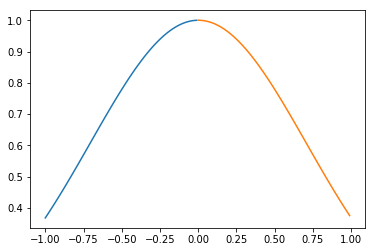

In [87]:
# Load ascii data from a file
data0 = np.genfromtxt("drawgau0.txt")
data1 = np.genfromtxt("drawgau1.txt")
# Plot!
plt.figure()
plt.plot(data0[:,0],data0[:,1])
plt.plot(data1[:,0],data1[:,1])
plt.show()

### Sharing Jobs, Files, and Applications

In [88]:
# By default, only you can see your jobs and job data
!jobs-pems-list ${JOB_ID}

stevenrbrandt READ WRITE 


In [89]:
# permissions: READ, WRITE, READ_WRITE, ALL, NONE
!jobs-pems-update -u ktraxler -p READ ${JOB_ID}

Successfully updated permission for ktraxler


In [90]:
!jobs-pems-list ${JOB_ID}

stevenrbrandt READ WRITE 
ktraxler READ 


In [91]:
# permissions: READ, WRITE, READ_WRITE, ALL, NONE
!jobs-pems-update -u ktraxler -p NONE ${JOB_ID}

Successfully updated permission for ktraxler


In [92]:
!jobs-pems-list ${JOB_ID}

stevenrbrandt READ WRITE 


In [93]:
!apps-pems-list ${APP_NAME}-1.0

stevenrbrandt READ WRITE EXECUTE 
ktraxler READ EXECUTE 
stevenrbrandt READ WRITE EXECUTE 


In [94]:
# permissions: READ, WRITE, EXECUTE, READ_WRITE, READ_EXECUTE, WRITE_EXECUTE, ALL, and NONE
!apps-pems-update -u ktraxler -p READ_EXECUTE ${APP_NAME}-1.0

Successfully updated permission for ktraxler


In [95]:
!apps-pems-list ${APP_NAME}-1.0

stevenrbrandt READ WRITE EXECUTE 
ktraxler READ EXECUTE 
stevenrbrandt READ WRITE EXECUTE 


In [96]:
!echo Click the link to submit and run a job
!echo https://togo.agaveapi.co/app/#/apps/${APP_NAME}-1.0/run

Click the link to submit and run a job
https://togo.agaveapi.co/app/#/apps/drawgau-shelob-stevenrbrandt-1.0/run
